<a href="https://colab.research.google.com/github/TarnNished/deep_learning_final/blob/main/data_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Storyteller — Data & Training

Full training notebook for image captioning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import json
import random
from collections import Counter
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CONFIG = {
    "image_size": 224,
    "embedding_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1,
    "batch_size": 512,
    "lr": 1e-3,
    "epochs": 15,
    "max_len": 30,
    "min_word_freq": 2
}


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/caption_data"
IMAGE_DIR = os.path.join(DATA_ROOT, "Images")
CAPTIONS_FILE = os.path.join(DATA_ROOT, "captions.txt")
ARTIFACTS_DIR = "/content/drive/MyDrive/visual-storyteller/artifacts"


In [ ]:
def load_captions(image_dir, captions_file):

    samples = []

    with open(captions_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # remove header if exists
    if lines[0].lower().startswith("image"):
        lines = lines[1:]

    for line in lines:
        image_name, caption = line.strip().split(",", 1)
        image_path = os.path.join(image_dir, image_name)

        if os.path.exists(image_path):
            samples.append((image_path, caption.lower()))

    return samples


In [ ]:
all_samples = load_captions(IMAGE_DIR, CAPTIONS_FILE)
print("Total (image, caption) pairs:", len(all_samples))


Total (image, caption) pairs: 40455


In [ ]:

random.shuffle(all_samples)
train_end = int(0.8 * len(all_samples))
val_end = int(0.9 * len(all_samples))
train_data = all_samples[:train_end]
val_data = all_samples[train_end:val_end]
test_data = all_samples[val_end:]


In [ ]:

SPECIAL_TOKENS = {"<pad>":0,"<bos>":1,"<eos>":2,"<unk>":3}

def build_vocab(captions, min_freq):
    counter = Counter()
    for c in captions:
        counter.update(c.split())
    vocab = dict(SPECIAL_TOKENS)
    idx = len(vocab)
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

vocab = build_vocab([c for _, c in train_data], CONFIG["min_word_freq"])
ivocab = {i:w for w,i in vocab.items()}
vocab_size = len(vocab)


In [ ]:

def encode_caption(caption, vocab, max_len):
    tokens = caption.split()
    encoded = [vocab.get(w, vocab["<unk>"]) for w in tokens]
    encoded = [vocab["<bos>"]] + encoded + [vocab["<eos>"]]
    encoded = encoded[:max_len]
    encoded += [vocab["<pad>"]] * (max_len - len(encoded))
    return torch.tensor(encoded)


In [ ]:

class CaptionDataset(Dataset):
    def __init__(self, data, vocab, transform):
        self.data = data
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        cap = encode_caption(caption, self.vocab, CONFIG["max_len"])
        return img, cap


In [ ]:

transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_loader = DataLoader(CaptionDataset(train_data, vocab, transform),
                          batch_size=CONFIG["batch_size"], shuffle=True)


In [ ]:

class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        resnet = models.resnet18(pretrained=True)

        # Remove classification head
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Project CNN features → embedding space
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)

    def forward(self, images):
        """
        images: (B, 3, H, W)
        returns: (B, embed_dim)
        """
        with torch.no_grad():  # freeze CNN
            feats = self.backbone(images)          # (B, 512, 1, 1)
            feats = feats.squeeze(-1).squeeze(-1) # (B, 512)

        return self.fc(feats)                      # (B, embed_dim)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        """
        features: (B, embed_dim)
        captions: (B, T)

        Training input sequence:
        [image_feature, <bos>, word1, word2, ...]
        """

        # Remove <eos> from input
        emb = self.embedding(captions[:, :-1])  # (B, T-1, E)

        # Image as first timestep
        features = features.unsqueeze(1)         # (B, 1, E)

        # Concatenate
        x = torch.cat((features, emb), dim=1)    # (B, T, E)

        out, _ = self.lstm(x)                     # (B, T, H)
        logits = self.fc(out)                     # (B, T, vocab)

        return logits


In [ ]:

encoder = Encoder(CONFIG["embedding_dim"]).to(DEVICE)
decoder = Decoder(vocab_size, CONFIG["embedding_dim"], CONFIG["hidden_dim"]).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.Adam(decoder.parameters(), lr=CONFIG["lr"])


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: Tesla T4


In [ ]:

train_losses = []
for epoch in range(CONFIG["epochs"]):
    encoder.eval()
    decoder.train()
    total_loss = 0
    for images, captions in tqdm(train_loader):
        images, captions = images.to(DEVICE), captions.to(DEVICE)
        feats = encoder(images)
        outputs = decoder(feats, captions)
        loss = criterion(
          outputs[:, 1:, :].reshape(-1, vocab_size),
          captions[:, 1:].reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(train_loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}: loss={avg:.4f}")


100%|██████████| 64/64 [05:12<00:00,  4.88s/it]


Epoch 1: loss=4.8737


100%|██████████| 64/64 [05:10<00:00,  4.85s/it]


Epoch 2: loss=3.7131


100%|██████████| 64/64 [05:12<00:00,  4.88s/it]


Epoch 3: loss=3.3807


100%|██████████| 64/64 [05:11<00:00,  4.86s/it]


Epoch 4: loss=3.1642


100%|██████████| 64/64 [05:10<00:00,  4.85s/it]


Epoch 5: loss=3.0087


100%|██████████| 64/64 [05:09<00:00,  4.84s/it]


Epoch 6: loss=2.8800


100%|██████████| 64/64 [05:08<00:00,  4.82s/it]


Epoch 7: loss=2.7687


100%|██████████| 64/64 [05:09<00:00,  4.83s/it]


Epoch 8: loss=2.6774


100%|██████████| 64/64 [05:12<00:00,  4.88s/it]


Epoch 9: loss=2.5968


100%|██████████| 64/64 [05:10<00:00,  4.84s/it]


Epoch 10: loss=2.5249


100%|██████████| 64/64 [05:12<00:00,  4.88s/it]


Epoch 11: loss=2.4582


100%|██████████| 64/64 [05:08<00:00,  4.82s/it]


Epoch 12: loss=2.3957


100%|██████████| 64/64 [05:08<00:00,  4.82s/it]


Epoch 13: loss=2.3383


100%|██████████| 64/64 [05:08<00:00,  4.81s/it]


Epoch 14: loss=2.2863


100%|██████████| 64/64 [05:08<00:00,  4.83s/it]

Epoch 15: loss=2.2312


In [ ]:
def evaluate(loader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in loader:
            images = images.to(DEVICE)
            captions = captions.to(DEVICE)

            feats = encoder(images)
            outputs = decoder(feats, captions)

            loss = criterion(
                outputs[:, 1:, :].reshape(-1, vocab_size),
                captions[:, 1:].reshape(-1)
            )
            total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:

os.makedirs("artifacts", exist_ok=True)
torch.save({"encoder":encoder.state_dict(),
            "decoder":decoder.state_dict()}, "artifacts/model.pt")
json.dump(vocab, open("artifacts/vocab.json","w"))
json.dump(CONFIG, open("artifacts/config.json","w"))
print("Saved artifacts")


Saved artifacts


In [ ]:
encoder.eval()
decoder.eval()

encoder.to(DEVICE)
decoder.to(DEVICE)


Decoder(
  (embedding): Embedding(4823, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=4823, bias=True)
)

In [ ]:
def generate_caption_one(image_path, max_len=30):
    encoder.eval()
    decoder.eval()

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        # Encode image
        features = encoder(image)            # (1, embed_dim)
        features = features.unsqueeze(1)     # (1, 1, embed_dim)

        # STEP 0 — image as first timestep (same as training)
        out, (h, c) = decoder.lstm(features)

        # Start token
        word = torch.tensor([[vocab["<bos>"]]], device=DEVICE)
        caption_words = []

        for _ in range(max_len):
            emb = decoder.embedding(word)          # (1, 1, embed_dim)
            out, (h, c) = decoder.lstm(emb, (h, c))
            scores = decoder.fc(out.squeeze(1))

            predicted = scores.argmax(dim=1)
            word = predicted.unsqueeze(1)

            token_id = predicted.item()
            if token_id == vocab["<eos>"]:
                break

            caption_words.append(ivocab.get(token_id, "<unk>"))

    return " ".join(caption_words)


Image exists: True


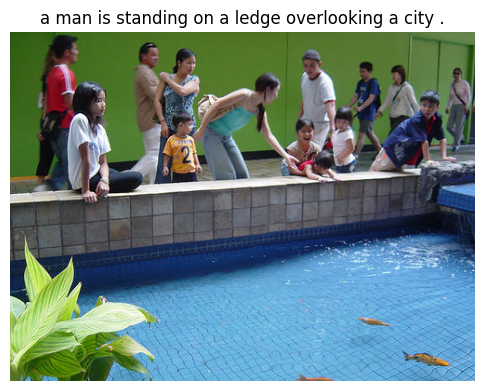

Generated caption: a man is standing on a ledge overlooking a city .


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_path = "/content/drive/MyDrive/caption_data/Images/12830823_87d2654e31.jpg"

# Sanity check: file exists
print("Image exists:", os.path.exists(image_path))

# Generate caption
caption = generate_caption_one(image_path)

# Display image with caption
img = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(caption)
plt.show()

print("Generated caption:", caption)
